# Cart Pole (Double DeepQ Learning + Replay Memory) 

In this notebook, we will solve the cart pole task using DeepQ Learning and a replay memory

In [1]:
import gym
import numpy as np
import random
import imageio 
import math
from matplotlib import pyplot as plt

## Context

In [2]:
env = gym.make('CartPole-v1')

The Cart Pole task aims to balance a pole that is attached to a cart which moves along an axis (left or right).

Here we can take 2 actions encoded as 'int' (0 or 1) : move left or move right.

In [3]:
env.action_space

Discrete(2)

The observation state is a vector of 4 numbers : cart position, cart velocity, pole angle and pole angular velocity. Some of these nubers are bounded, other are not.

What's important is that the state is not discrete, so there is an infinite combination of state, making a QTable for such a problem is possible but not the right solution because of the infinite amount of state.

In [4]:
env.observation_space.shape

(4,)

If a QTable is not the right solution, the only remaining is using DeepQ Learning.

Instead of creating a table that will store all the Qvalues, we use a neural network to approximatethose QValues. The neural network allow us to have an infinite number of states, it will only depends on the network's weights and not a static table.

## DeepQ Learning (With replay memory)

The difference between a simple DeepQ Learning alogorithm and another one using replay memory is that the first one will only learn from its last experience, unlike the other one that can learn from past experience. 

This simple make a huge difference, because without memory the model can't generalize well, and is very likely to not train on every possible situations.

### Replay Memory (deque)
First create the replay memory, that will store : the current state, the action taken, the reward, the next state, and if the state is terminal.

Basically, the memory doesn't have an infinite capcity (performance wise), so we setup the memory as a deque, it will automatically handle incoming experience, and throwing the older ones.


The methods created are :
- 'push' : it append a new experience to the memory
- 'sample' : it will randomly take some experience (a batch) in the memory and output them, those will be used to update the network weights.
- '__len__' : it overrides the 'len' methods to return the memory length, used to start updating network's weights when there are enough experience stored.

In [5]:
from collections import deque
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

### The network

The network can be set how you want, but because here is a quite simple case with not a huge amount of state, it doesn't need to be a very deep network, 3 simple dense layer with 32 units are sufficient.


The input_shape or input, is what is received, the observation so a vector 4 values (Shape : (4,)).

The output are the QValues for the possible actions, here the QValues for going left or right. Because its numbers, the activation is linear, and the losss is MSE.

In [6]:
from keras import layers, Sequential, optimizers
def create_model(input_shape, output_shape, learning_rate):
    model = Sequential()
    model.add(layers.Dense(64, input_shape=(input_shape,), activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(output_shape, activation='linear'))
    return model

### DeepQ Learning algorithm

In [7]:
rewards_list = []

def DeepQLearning(env, learning_rate, discount, epsilon, max_steps, episodes, batch_size_p=32):
    
    input_shape = env.observation_space.shape[0]
    output_shape = env.action_space.n

    model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=learning_rate)
    target_model =  create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = learning_rate))


    memory = ReplayMemory(capacity=250000)
    batch_size = batch_size_p
    

    for i in range(episodes):
        state, info = env.reset()
        state = state.reshape(1, input_shape)
        done = False
        reward_tot = 0


        if i%10 == 0:
            target_model.set_weights(model.get_weights())

        model.save_weights("model.weightsDDQN.h5")

        
        for j in range (max_steps):   



            if np.random.rand() <= epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(model.predict(state, verbose=0)[0])


            new_state, reward, done, truncated, info = env.step(action)
            new_state = new_state.reshape(1, input_shape) 
            reward_tot += reward

            memory.push(state, action, reward, new_state, done)
            state = new_state

            
            # Only update the model if there are enough experiences in memory
            if len(memory) >= batch_size:
                
                states, actions, rewards, new_states, dones = zip(*memory.sample(batch_size))

                
                dones = np.array(dones, dtype=np.bool_)
                #states = np.array(states)
                states = np.squeeze(states)
                ####
                actions = np.array(actions)
                ####
                
                #new_states = np.array(new_states)
                new_states = np.squeeze(new_states)
                
                targets = model.predict_on_batch(states)

                #q_values_next = target_model.predict_on_batch(new_states)
                q_values_next = target_model.predict_on_batch(new_states)


                max_q_values_next = np.amax(q_values_next, axis=1)
                
                targets[range(batch_size), actions] = rewards + discount * max_q_values_next *  (1 - dones) 

                model.fit(states, targets, epochs=1, verbose=0)

                model.save_weights('modelv12548DDQN.weights.h5', overwrite=True)
                
                if i>10 and epsilon > 0.01:
                    epsilon *= 0.9995

            if done:
                rewards_list.append(reward_tot)
                print("Episodes n°:", i, "Epsilon:", epsilon, "Total reward:", j)
                break




In [8]:
DeepQLearning(env, 
          learning_rate=0.001, 
          discount=0.95, 
          epsilon=1.0, 
          max_steps=10000, 
          episodes=1000,
          batch_size_p=32)

c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodes n°: 0 Epsilon: 1.0 Total reward: 14
Episodes n°: 1 Epsilon: 1.0 Total reward: 31
Episodes n°: 2 Epsilon: 1.0 Total reward: 24
Episodes n°: 3 Epsilon: 1.0 Total reward: 25
Episodes n°: 4 Epsilon: 1.0 Total reward: 24
Episodes n°: 5 Epsilon: 1.0 Total reward: 35
Episodes n°: 6 Epsilon: 1.0 Total reward: 18
Episodes n°: 7 Epsilon: 1.0 Total reward: 21
Episodes n°: 8 Epsilon: 1.0 Total reward: 34
Episodes n°: 9 Epsilon: 1.0 Total reward: 11
Episodes n°: 10 Epsilon: 1.0 Total reward: 19
Episodes n°: 11 Epsilon: 0.9826479351373822 Total reward: 34
Episodes n°: 12 Epsilon: 0.9728679918326804 Total reward: 19
Episodes n°: 13 Epsilon: 0.9670468094797544 Total reward: 11
Episodes n°: 14 Epsilon: 0.9593393788247946 Total reward: 15
Episodes n°: 15 Epsilon: 0.9422215132683146 Total reward: 35
Episodes n°: 16 Epsilon: 0.9361154131092286 Total reward: 12
Episodes n°: 17 Epsilon: 0.916198822899158 Total reward: 42
Episodes n°: 18 Epsilon: 0.9102613637141588 Total reward: 12
Episodes n°: 19 E

KeyboardInterrupt: 

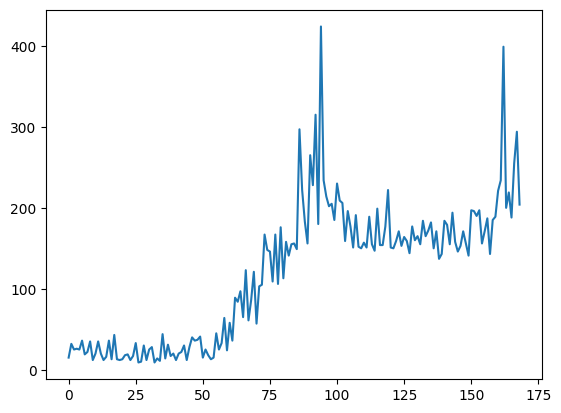

In [9]:
plt.plot(rewards_list)

In [10]:
images = []
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
state,info = env.reset()


input_shape = env.observation_space.shape[0]
output_shape = env.action_space.n

state = state.reshape(1, input_shape)


model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=0.001
)
model.load_weights('model.weightsDDQN.h5')
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

score = 0
done = False
while not done:

        action = np.argmax(model.predict(state, verbose=0))
        new_state, reward, done, trunc, info = env.step(action)
        state = new_state.reshape(1, input_shape) 

        frame = env.render()  # Save the frame
        images.append(frame)


        if done == True:
                break
        score +=1

env.close()
imageio.mimsave('img/CartPoleDDQN1.gif', images, fps=59)